In [1]:
import xarray as xr
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt 
from matplotlib import ticker, cm
import matplotlib.cm as mcm
from matplotlib.ticker import MaxNLocator
import matplotlib.colors as colors
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
from matplotlib.ticker import FuncFormatter
jet = mcm.get_cmap('jet') if isinstance(mcm.get_cmap('jet'), str) else mcm.get_cmap('jet')
import netCDF4 as nc
import cartopy.crs as ccrs # CRS stands for "Coordinate reference systems" for map projection
from cartopy.crs import PlateCarree
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter 
import matplotlib.gridspec as gridspec
import os 
import glob
import re
import nc_time_axis
import time 
import dask.array as da

/tmp/ipykernel_207622/1496084063.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = mcm.get_cmap('jet') if isinstance(mcm.get_cmap('jet'), str) else mcm.get_cmap('jet')


In [2]:
bound_path = '/nobackup/earfw/cesm2_inputdata//atm/waccm/lb/LBC_1765-2100_1.9x2.5_CCMI_RCP60_za_c130313.nc'
bound_file = xr.open_dataset(bound_path, decode_times=False)
bound_file

<xarray.Dataset>
Dimensions:            (lat: 96, lon: 144, time: 4033)
Coordinates:
  * lat                (lat) float32 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * lon                (lon) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * time               (time) float32 0.0 31.01 58.99 ... 1.226e+05 1.226e+05
Data variables: (12/33)
    date               (time) int32 ...
    CFCL3_LBC          (time, lat) float32 ...
    CF2CL2_LBC         (time, lat) float32 ...
    CFC113_LBC         (time, lat) float32 ...
    CFC114_LBC         (time, lat) float32 ...
    CFC115_LBC         (time, lat) float32 ...
    ...                 ...
    CO2_LBC_mean       (time) float32 ...
    H2_LBC             (time, lat) float32 ...
    TOT_CLOY           (time, lat) float32 ...
    TOT_BROY           (time, lat) float32 ...
    TOT_FOY            (time, lat) float32 ...
    SF6_LBC            (time, lat) float32 ...
Attributes:
    Title:    Time dependent fixed vmr surface boundary conditions
    source:   File created by Doug Kinnison, NCAR,  dkin@ucar,edu
    comment:  NH/SH gradient for CH3Br, HCFC22, HCFC141b, HCFC142b

In [3]:
med_timesl = bound_file.sel(time=85770, method = 'nearest')
print(med_timesl['date'].item())

med_co2_vmr = med_timesl['CO2_LBC_mean'].item()
print(f'CO2 volume mixing ratio = {med_co2_vmr}')
med_ch4_vmr = med_timesl['CH4_LBC_mean'].item()
print(f'CH4 volume mixing ratio = {med_ch4_vmr}')
med_n2o_vmr = med_timesl['N2O_LBC'].mean(dim='lat').item()
print(f'N2O volume mixing ratio = {med_n2o_vmr}')

cli_timesl = bound_file.sel(time=122640.0)
print(cli_timesl['date'].item())

### Mixing Ratios ###

cli_co2_vmr = cli_timesl['CO2_LBC_mean'].item()
print(f'CO2 volume mixing ratio = {cli_co2_vmr}')
cli_ch4_vmr = cli_timesl['CH4_LBC_mean'].item()
print(f'CH4 volume mixing ratio = {cli_ch4_vmr}')
cli_n2o_vmr = cli_timesl['N2O_LBC'].mean(dim='lat').item()
print(f'N2O volume mixing ratio = {cli_n2o_vmr}')

20000101
CO2 volume mixing ratio = 0.00036810588790103793
CH4 volume mixing ratio = 1.7501276943221455e-06
N2O volume mixing ratio = 3.1555376267533575e-07
21010101
CO2 volume mixing ratio = 0.0006713724578730762
CH4 volume mixing ratio = 1.6423263105025399e-06
N2O volume mixing ratio = 4.067120755735232e-07


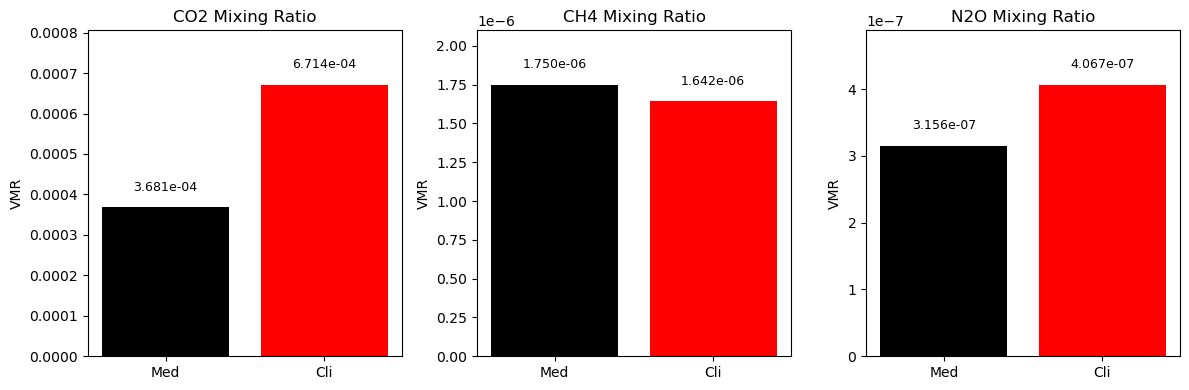

In [9]:
import matplotlib.pyplot as plt

# Setup for subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=False)

# Data for each subplot
species = ['CO2', 'CH4', 'N2O']
med_values = [med_co2_vmr, med_ch4_vmr, med_n2o_vmr]
cli_values = [cli_co2_vmr, cli_ch4_vmr, cli_n2o_vmr]

colors = ['black', 'red']

for i in range(3):
    axs[i].bar(['Med', 'Cli'], [med_values[i], cli_values[i]], color=colors)
    axs[i].set_title(f'{species[i]} Mixing Ratio')
    axs[i].set_ylabel('VMR')
    axs[i].set_ylim(0, max(med_values[i], cli_values[i]) * 1.2)

    # Add value labels
    for j, val in enumerate([med_values[i], cli_values[i]]):
        axs[i].text(j, val + (max(med_values[i], cli_values[i]) * 0.05), f'{val:.3e}',
                    ha='center', va='bottom', fontsize=9)

# Layout and display
plt.tight_layout()
plt.savefig(f'/home/home02/cm21cmr/Sporadic-E-Project/Figures/inital_boundary_con', dpi=400, bbox_inches='tight')
plt.show()


In [5]:
cli_ref_path = '/resstore/b0243/Data/Sporadic_E/FX2100f19f19mg16NaFeMgiontransport_OUTPUT/hist/FX2100f19f19mg16NaFeMgiontransport.cam.h0.2100-07.nc'
cli_ref_file = xr.open_dataset(cli_ref_path, decode_times=False)
cli_ref_file = cli_ref_file.mean(dim='lat')
cli_ref_file = cli_ref_file.mean(dim='lon')
cli_ref_file = cli_ref_file.sel(
                        # lev=0.0002, 
                        time=31.1, 
                        method='nearest')
cli_ref_file

<xarray.Dataset>
Dimensions:          (mlat: 97, mlon: 80, zlon: 1, nbnd: 2, lev: 126, ilev: 127)
Coordinates:
  * mlat             (mlat) float64 -90.0 -88.12 -86.24 ... 86.24 88.12 90.0
  * mlon             (mlon) float64 -180.0 -175.5 -171.0 ... 166.5 171.0 175.5
  * zlon             (zlon) float64 0.0
  * lev              (lev) float64 4.055e-10 5.207e-10 6.686e-10 ... 970.6 992.6
  * ilev             (ilev) float64 3.551e-10 4.559e-10 ... 985.1 1e+03
    time             float64 212.0
Dimensions without coordinates: nbnd
Data variables: (12/587)
    gw               float64 0.02083
    zlon_bnds        (zlon, nbnd) float64 0.0 357.5
    hyam             (lev) float64 4.055e-13 5.207e-13 ... 0.001261 0.0
    hybm             (lev) float64 0.0 0.0 0.0 0.0 ... 0.9248 0.9693 0.9926
    P0               float64 1e+05
    hyai             (ilev) float64 3.551e-13 4.559e-13 5.854e-13 ... 0.0 0.0
    ...               ...
    WD_HOCL          float32 -1.288e-14
    WI               (lev) float32 0.2676 0.2668 0.2661 ... 0.2433 0.2433 0.2433
    WTHzm            (ilev, zlon) float32 -13.54 5.021e+03 ... 1.574e+34
    Z3               (lev) float32 5.319e+05 5.194e+05 5.07e+05 ... 634.9 449.2
    e                (lev) float32 0.027 0.02322 0.02006 ... 9.082e-23 9.083e-23
    e_SRF            float32 9.083e-23

In [ ]:
R = 287
cli_n = cli_ref_file['lev']*100/(R*cli_ref_file['T'])
# n = n.item()
# print(cli_n)

In [ ]:
cli_o_concentration = cli_ref_file['O']*cli_n
cli_o = cli_o_concentration

cli_o2_concentration = cli_ref_file['O2']*cli_n
cli_o2 = cli_o2_concentration

cli_o3_concentration = cli_ref_file['O3']*cli_n
cli_o3 = cli_o3_concentration

cli_e_concentration = cli_ref_file['EDens']*cli_n
cli_e = cli_e_concentration

cli_T = cli_ref_file['T']
cli_m = 2e13

cli_n2 = 0.8*cli_m

In [ ]:
cli_k11 = 7.6e-10* (np.exp(-241/cli_T))        #'Fe+ + O3 --> FeO+ + O2, from Rollason and Plane
cli_k12 = 3.0e-11                              #'FeO+ + O --> Fe+ + O2
cli_k13 = 4.1e-30*((cli_T/300)**-1.52)*cli_m   #'Fe+ + N2 + He, from Rollason and Plane
cli_k14 = 8.3e-30*((cli_T/300)**-1.86)*cli_m   #'Fe+ + O2 + He, from Rollason and Plane
cli_k15 = 5.0e-11                                  #'Fe+.N2 or FeO2+ + O --> FeO+ + N2 or O2
cli_k16 = 3.0e-7*((200/cli_T)**0.5)                #'Fe.X+ + e --> Fe + X

cli_rate = ( (cli_k13*cli_n2 + cli_k14*cli_o2)*cli_k15*cli_o/(cli_k15*cli_o+cli_k16*cli_e) + cli_k11*cli_o3)      *cli_k16*cli_e   /         (cli_k16*cli_e+cli_k12*cli_o)
cli_rate = cli_rate + (cli_k13*cli_n2+cli_k14*cli_o2)*(cli_k16*cli_e/(cli_k15*cli_o+cli_k16*cli_e))  

# The e-folding lifetime of Fe+ against neutralization is then 1/rate

cli_lifetime = 1 / cli_rate
print(cli_lifetime)

In [ ]:
med_ref_path = '/resstore/b0243/Data/Sporadic_E/Solar_Med/archive_yr2000/ACP_CESM213_FX2000_f19_f19_mg16_Na_Fe_Mg_iontransport.cam.h0.0001-07.nc'
med_ref_file = xr.open_dataset(med_ref_path, decode_times=False)
med_ref_file = med_ref_file.mean(dim='lat')
med_ref_file = med_ref_file.mean(dim='lon')
med_ref_file = med_ref_file.sel(
                        # lev=0.0002, 
                        time=31.1, 
                        method='nearest')
med_ref_file

In [ ]:
R = 287
med_n = med_ref_file['lev']*100/(R*med_ref_file['T'])
# n = n.item()
# print(cli_n)

In [ ]:
med_o_concentration = med_ref_file['O']*med_n
med_o = med_o_concentration

med_o2_concentration = med_ref_file['O2']*med_n
med_o2 = med_o2_concentration

med_o3_concentration = med_ref_file['O3']*med_n
med_o3 = med_o3_concentration

med_e_concentration = med_ref_file['EDens']*med_n
med_e = med_e_concentration

med_T = med_ref_file['T']
med_m = 2e13

med_n2 = 0.8*med_m

In [ ]:
med_k11 = 7.6e-10* (np.exp(-241/med_T))           #'Fe+ + O3 --> FeO+ + O2, from Rollason and Plane
med_k12 = 3.0e-11                                 #'FeO+ + O --> Fe+ + O2
med_k13 = 4.1e-30*((med_T/300)**-1.52)*med_m      #'Fe+ + N2 + He, from Rollason and Plane
med_k14 = 8.3e-30*((med_T/300)**-1.86)*med_m      #'Fe+ + O2 + He, from Rollason and Plane
med_k15 = 5.0e-11                                 #'Fe+.N2 or FeO2+ + O --> FeO+ + N2 or O2
med_k16 = 3.0e-7*((200/med_T)**0.5)               #'Fe.X+ + e --> Fe + X

med_rate = ( (med_k13*med_n2 + med_k14*med_o2)*med_k15*med_o/(med_k15*med_o+med_k16*med_e) + med_k11*med_o3) *med_k16*med_e/(med_k16*med_e+med_k12*med_o)
med_rate = med_rate + (med_k13*med_n2+med_k14*med_o2)*(med_k16*med_e/(med_k15*med_o+med_k16*med_e))  

# The e-folding lifetime of Fe+ against neutralization is then 1/rate

med_lifetime = 1 / med_rate
print(med_lifetime)

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))

ax.plot(cli_lifetime, cli_lifetime.lev, label='Year 2100', color='red')
ax.plot(med_lifetime, med_lifetime.lev, label='SMed', color='black')
ax.set_ylabel('Level / hPa')
ax.set_ylim(1e-2, 1e-6)
ax.set_yscale('log')
ax.set_xlabel('Lifetime / s')
ax.set_xlim(300,1000)
ax.set_title('The change in e-folding lifetime of Fe+ against neutralization with height')
ax.legend()
plt.tight_layout()
plt.savefig(f'/home/home02/cm21cmr/Sporadic-E-Project/Figures/Fep_lifetime_cli_vs_med', dpi=400, bbox_inches='tight')
plt.show()